In [2]:
import math
import os
from scipy.odr import * # librería para ajustes
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf   # función error
import scipy.constants as cte   # constantes físicas

In [3]:
class Espectro:
    
    # clase para guardar todos los datos del espectro de manera compacta
    
    def __init__(self):
    
        self.fuente = None
        self.cuentas = []
        self.canales = []
        self.espesor = None

In [4]:
# Lectura de datos

espectros = {}  # me creo un diccionario para separar todos los espectros

carpeta = 'Datos_2021/Formateados/' # Carpeta donde están los datos formateados de todos los 
                                    # espectros

for filename in os.listdir(carpeta):
    elem,d = filename.split("mm.S")[0].split("_")   # me quedo sólo con el nombre y el espesor

    temp_file = open(carpeta+filename, "r")
    temp_list = [int(x) for x in temp_file.readlines()]

    temp_spec = Espectro()
        
    temp_spec.fuente = elem
    temp_spec.espesor = float(d)
    temp_spec.canales = [ch for ch in range(len(temp_list))]
    temp_spec.cuentas = temp_list
    
    if elem in list(espectros):
        espectros[elem].append(temp_spec)
    else:
        espectros[elem] = []
        espectros[elem].append(temp_spec)

# Chequeo que esté todo bien definido
#print(list(espectros))
#
#for elem in espectros.keys():
#    for i in range(len(espectros[elem])):
#        print(espectros[elem][i].fuente,espectros[elem][i].espesor,len(espectros[elem][i]#.canales),len(espectros[elem][i].cuentas))

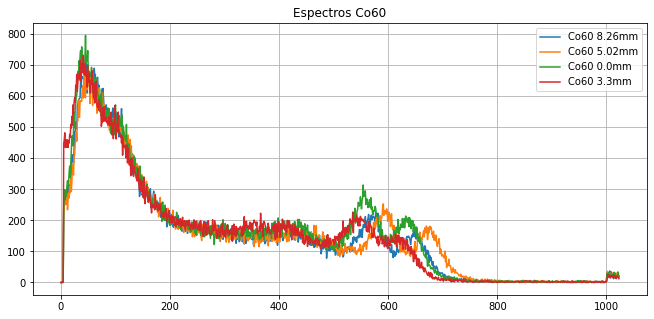

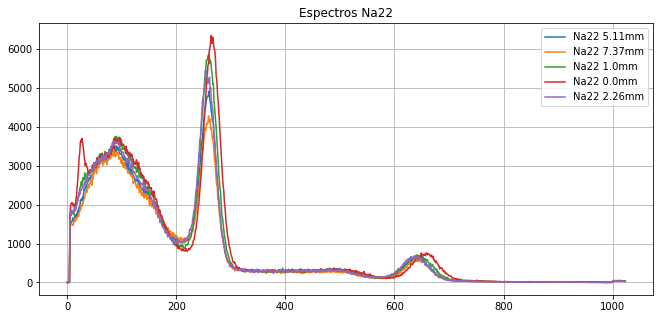

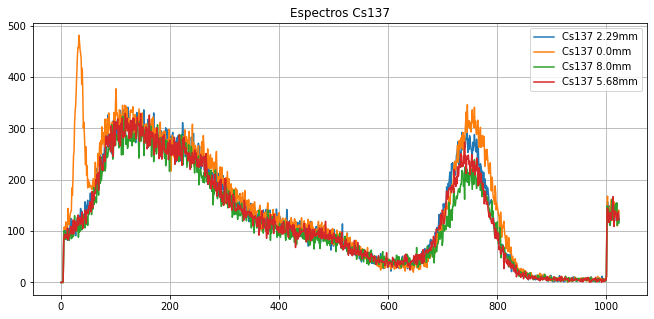

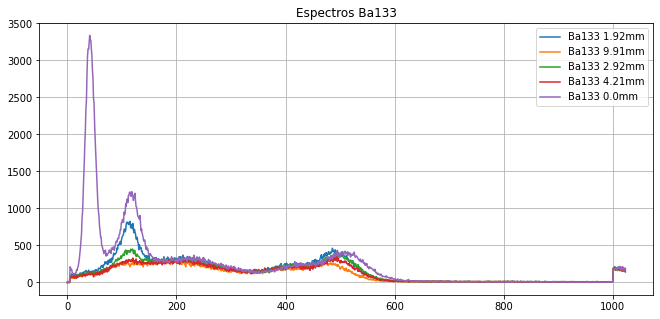

In [5]:
# ploteamos para ver que todo este bien    

for key in espectros.keys():
    
    fig = plt.figure(figsize=(11,5))
    
    for spec in espectros[key]:
        plt.plot(spec.cuentas, label='{} {}mm'.format(key,spec.espesor))
    
    plt.title("Espectros {}".format(key))
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# todas las funciones que voy a usar para los ajustes de ODR
# con y sin fondo, inicialmente uso un modelo de decaimiento exponencial
# mientras sea consistente con el fondo, dado que estoy viendo caidas de intensidad y no
# intensidad absoluta no deberia haber problema 

def fondo(B,x):
    # función error
    return B[0]*(1-erf(B[1]*(x-B[2])))

def gaussian(B,x):
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2))

def dgaussian(B,x):
    # gaussiana doble
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*np.exp(-(x-B[4])**2/(2*B[5]**2))

def gaussian_exp(B,x):
    # gaussiana y función error
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*(1-erf(B[4]*(x-B[5])))

def dgaussian_exp(B,x):
    #gaussiana doble y función error
    return B[0]*np.exp(-(x-B[1])**2/(2*B[2]**2)) + B[3]*np.exp(-(x-B[4])**2/(2*B[5]**2)) + B[6]*(1-erf(B[7]*(x-B[8])))

# como intensidad uso la integral de -inf a inf porque lo hago sobre la gaussiana desacoplada 
def int_gaussiana(sigma, I_0):
    # intensidad del pico
    return np.sqrt(2*np.pi)*sigma*I_0

def err_int_gaussiana(sigma, I_0, err_sigma, err_I_0):
    # error en la intensidad del pico
    return np.sqrt(2*np.pi)*np.sqrt((I_0*err_sigma)**2 + (sigma*err_I_0)**2)

In [7]:
# esta funcion me deja fittear en las 4 posibles combinaciones que puedo necesitar

def fit_gaussians(x_data, y_data, N_gauss=1, fondo=None, p_init=None):
    
    # armo x e y para ODR y tomo el error como la mitad del ultimo digito
    
    N = len(x_data) # para calcular los grados de libertad del chi cuadrado reducido
    x = x_data
    y = y_data
    sx = 1
    sy = np.sqrt(1/2**2+np.array(y_data))   # el desvío estándar de un proceso de Poisson se 
                                            # estima como sqrt(cuentas)
    
    # elijo el modelo, fijo el numero de parametros y condiciones iniciales dependiendo
    # de la cantidad de gaussianas y si tiene fondo o no
    
    if N_gauss == 1:
        if fondo == 'exp':
            gaussian_model = Model(gaussian_exp)
            N_params = 5
            beta0 = [1,1,1,1,1,1] if p_init == None else p_init
            
        else:
            gaussian_model = Model(gaussian)
            N_params = 3
            beta0 = [1,1,1] if p_init == None else p_init
            
    else:
        if fondo == 'exp':
            gaussian_model = Model(dgaussian_exp)
            N_params = 8
            beta0 = [1,1,1,1,1,1,1,1,1] if p_init == None else p_init
            
        else:
            gaussian_model = Model(dgaussian)
            N_params = 6
            beta0 = [1,1,1,1,1,1] if p_init == None else p_init
        
    
    # paso todos los datos a ODR para hacer el fit
    
    data = RealData(x,y,sx,sy)
    odr_fit = ODR(data, gaussian_model, beta0=beta0)
   
    # calculo el fit y finalmente devuelvo los parametros que me interesan 
    
    odr_fit_output = odr_fit.run()
    
    fit_params = odr_fit_output.beta
    err_fit_params = odr_fit_output.sd_beta
    chi_red_dof = odr_fit_output.res_var/(N-N_params)

    return fit_params, err_fit_params, chi_red_dof

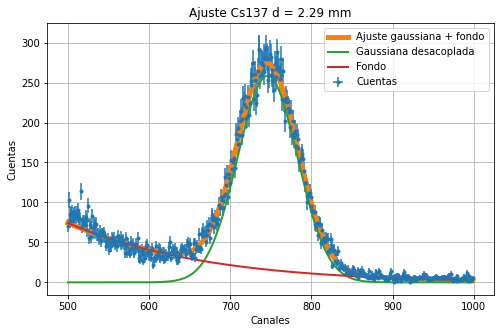

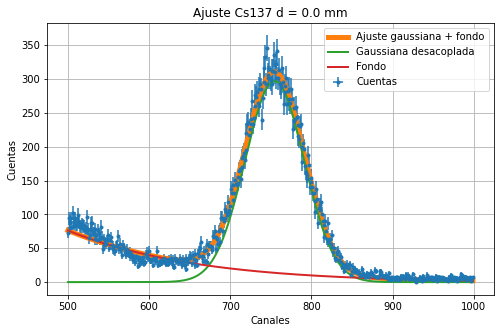

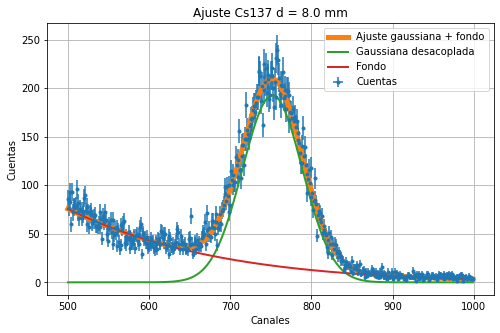

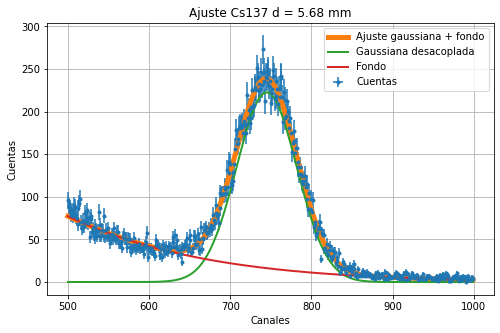

In [8]:
# aca voy a guardar los datos de intensidades para hacer despuees el ajuste 

d_cs137 = []
I_cs137 = []
err_I_cs137 = []

for spec in espectros['Cs137']:
    
    d = spec.espesor
    x = spec.canales[500:1000]  # Selecciono el rango a ajustar
    y = spec.cuentas[500:1000]
    
    p,err_p,chi = fit_gaussians(x, y, N_gauss=1,fondo= 'exp', p_init = [321,751,40,50,0.01,550])
    
    I_0 = p[0]  # amplitud de la gaussiana
    sigma = p[2] 
    
    # guardo tambien los errores para despues propagar 
    
    err_I_0 = err_p[0]
    err_sigma = err_p[2]
    
    d_cs137.append(d/10) # en cm
    I_cs137.append(int_gaussiana(sigma, I_0))
    err_I_cs137.append(err_int_gaussiana(sigma, I_0, err_sigma, err_I_0))
    
    
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(x, y, xerr=0.5, yerr=np.sqrt(1/2**2+np.array(y)), fmt = '.', label='Cuentas')
    plt.plot(x, gaussian_exp(p, x), linewidth=5, label='Ajuste gaussiana + fondo')
    plt.plot(x, gaussian(p[:3], x), linewidth=2,label='Gaussiana desacoplada')
    plt.plot(x, fondo(p[3:], x), linewidth=2, label='Fondo')
    plt.title("Ajuste Cs137 d = {} mm".format(d))
    plt.xlabel("Canales")
    plt.ylabel("Cuentas")
    plt.legend()
    plt.grid()
    plt.show()

mu: 0.505272765560787 +/- 0.028876703323266147 

mu/rho : 0.056581496703335614 +/- 0.0032342940792803644 

chi_dof**2:  0.8184408738990843 



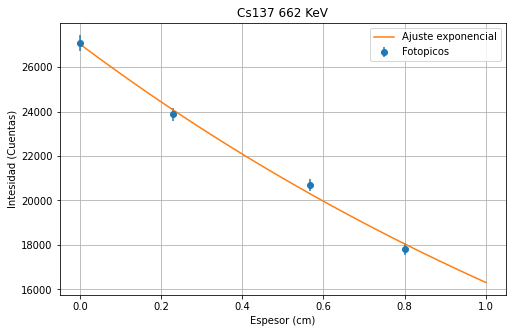

In [14]:
# los paso a arrays para que me lo tome odr

d_cs137 = np.array(d_cs137)
I_cs137 = np.array(I_cs137)
err_I_cs137 = np.array(err_I_cs137)

d_cs137_cont = np.linspace(0,1) # este lo voy a usar para plottear el ajuste

rho_cobre = 8.93 # densidad del cobre en g/cm**3, me interesa medir el coef de atenuación másico
err_rho_cobre = 0.01

def exp(B,x):
    return B[0]*np.exp(-B[1]*x)

exp_model = Model(exp)

data = RealData(d_cs137,I_cs137, sx = 1e-3, sy = err_I_cs137)
odr_fit = ODR(data, exp_model, beta0=[3e4,1e-2])
   
# calculo el fit y finalmente devuelvo los parametros que me interesan 
    
odr_fit_output = odr_fit.run()
fit_params = odr_fit_output.beta
err_fit_params = odr_fit_output.sd_beta
chi_red_dof = odr_fit_output.res_var/(len(I_cs137)-2)

# propago el error para mu que aparece por la densidad

mu = fit_params[1]
err_mu = err_fit_params[1]

mu_rho = mu/rho_cobre
err_mu_rho = mu_rho*np.sqrt((err_mu/mu)**2 + (err_rho_cobre/rho_cobre)**2)

print("mu:", mu, "+/-", err_mu, '\n')
print("mu/rho :", mu_rho, "+/-", err_mu_rho,'\n')
print("chi_dof**2: ", chi_red_dof,'\n')

# grafico

fig = plt.figure(figsize=(8,5))
plt.errorbar(d_cs137,I_cs137, yerr = err_I_cs137, fmt = 'o', label='Fotopicos')
plt.plot(d_cs137_cont, exp(fit_params,d_cs137_cont), label='Ajuste exponencial')
plt.xlabel("Espesor (cm)")
plt.ylabel("Intesidad (Cuentas)")
plt.title(r"Cs137 662 KeV")
plt.grid()
plt.legend()
plt.show()

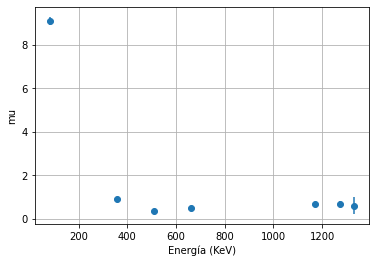

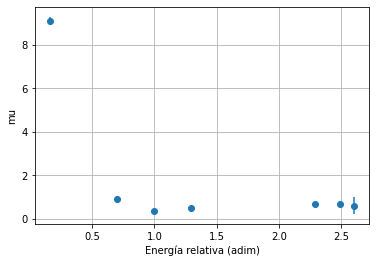

In [10]:
# valores de mu para las distintas fuentes reportados por todos los grupos
mus=[9.1,0.9,0.35,0.51,0.66,0.7,0.6] 
errmus=[0.2,0.1,0.03,0.03,0.05,0.1,0.4]
en=[81,356,511,662,1173,1275,1332]
k = [e/511 for e in en]     # energía adimensionalizada

plt.errorbar(en,mus,errmus,fmt='o')
plt.xlabel("Energía (KeV)")
plt.ylabel("mu")
plt.grid()
plt.show()

plt.errorbar(k,mus,errmus,fmt='o')
plt.xlabel("Energía relativa (adim)")
plt.ylabel("mu")
plt.grid()
plt.show()

In [11]:
# Funciones a ajustar

### las difíciles

def SE_fotoelFeo_k(A,k): #unidads de energía?
    return A/np.array(k)**(7/2)

def SE_kleinNishina_alp(B,alp):
    #alp=np.array(E)/cte.m_e/cte.c**2
    return B*((1+alp)/alp**2*(2*(1+alp)/(1+2*alp)-np.log(1+2*alp)/alp)+1/2/alp*np.log(1+2*alp)-(1+3*alp)/(1+2*alp)**2)

### las fáciles

def SE_fotoel_k(A,k):
    return A/np.array(k**3)

def SE_compton_k(B,k):
    return B/np.array(k)

def SE_pares_k(C,k):
    kk = np.array(k)
    return np.piecewise(kk, [kk < 2, kk >= 2],[0, C*np.array(np.log(kk[kk >= 2]/2))])

### las sumas

# las fáciles
def SE_suma(C,k):
    return C[0]*SE_fotoel_k(1,k)+C[1]*SE_compton_k(1,k)+C[2]*SE_pares_k(1,k)

def SE_suma_npar(C,k):
    return C[0]*SE_fotoel_k(1,k)+C[1]*SE_compton_k(1,k)

#las difíciles
def SE_suma_dif(C,k):
    return C[0]*SE_fotoelFeo_k(1,k)+C[1]*SE_kleinNishina_alp(1,k)+C[2]*SE_pares_k(1,k)

def SE_suma_dif_npar(C,k):
    return C[0]*SE_fotoelFeo_k(1,k)+C[1]*SE_kleinNishina_alp(1,k)

#la deforme
def SE_suma_func(C,k,func):
    suma = np.array()
    for f in range(len(func)):
        suma += C[f]*func[f](1,k)
    return suma

In [12]:
# ajuste

def odr_perritou(func,nroparam,betacero):
    exp_model = Model(func)

    data = RealData(k,mus, sx = 1/511, sy = errmus)
    odr_fit = ODR(data, exp_model, beta0=beta_cero)

    odr_fit_output = odr_fit.run()
    fit_params = odr_fit_output.beta
    err_fit_params = odr_fit_output.sd_beta
    chi_red_dof = odr_fit_output.res_var/(len(mus)-nroparam)

    print("params:\t\t", fit_params, '\n')
    print("err_params:\t", err_fit_params, '\n')
    print("chi_dof**2:\t", chi_red_dof,'\n')

    return fit_params

# gráfico
def h_plotter(func,params,log):
    kx=np.linspace(70/511,1400/511)
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(k,mus, yerr = errmus, fmt = 'o', label='Experimental')
    plt.plot(kx, func(fit_params,kx), label='Ajuste')
    plt.xlabel("Energía relativa (adim)")
    plt.ylabel("mu (cm^-1)")
    plt.title(r"Coeficiente de atenuación lineal del cobre")
    plt.grid()
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.legend()
    plt.show()

---------------------------------------------------------------------
foto -3, Comp -1, con pares
params:		 [0.02459606 0.46158937 2.8803483 ] 

err_params:	 [0.0051773  0.08110509 1.0010778 ] 

chi_dof**2:	 3.0940472556309424 



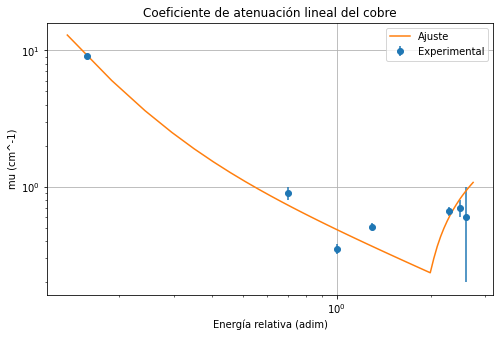

---------------------------------------------------------------------
foto 3, Comp -1, sin pares
params:		 [0.02324651 0.51042616] 

err_params:	 [0.00793233 0.12434465] 

chi_dof**2:	 6.0834521831676 



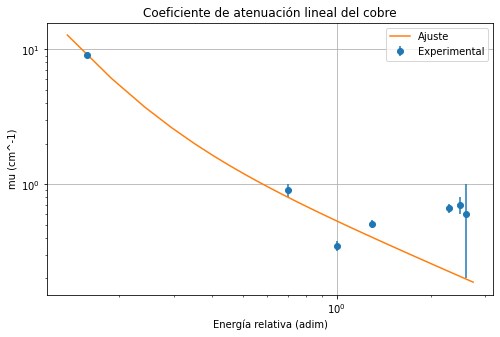

---------------------------------------------------------------------
foto -7/2, Comp K-N, con pares
params:		 [0.013128   0.79949423 2.20200299] 

err_params:	 [0.0020486  0.11751379 0.91021341] 

chi_dof**2:	 2.4286373969127006 



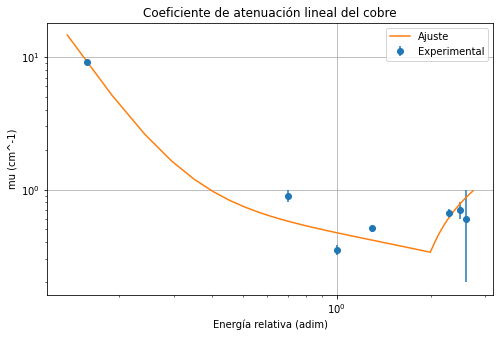

---------------------------------------------------------------------
foto -7/2, Comp K-N, sin pares
params:		 [0.01294963 0.88596493] 

err_params:	 [0.00284619 0.15718468] 

chi_dof**2:	 3.830052556554082 



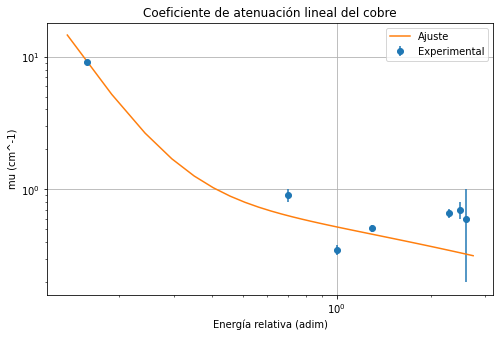

In [13]:
# las fáciles
print("---------------------------------------------------------------------")
print("foto -3, Comp -1, con pares")
beta_cero = [300,30,0.3]
fit_params = odr_perritou(SE_suma,3,beta_cero)
h_plotter(SE_suma,fit_params,1)

print("---------------------------------------------------------------------")
print("foto 3, Comp -1, sin pares")
beta_cero = [300,30]
fit_params = odr_perritou(SE_suma_npar,2,beta_cero)
h_plotter(SE_suma_npar,fit_params,1)

# las difíciles
print("---------------------------------------------------------------------")
print("foto -7/2, Comp K-N, con pares")
beta_cero = [300,30,0.3]
fit_params = odr_perritou(SE_suma_dif,3,beta_cero)
h_plotter(SE_suma_dif,fit_params,1)

print("---------------------------------------------------------------------")
print("foto -7/2, Comp K-N, sin pares")
beta_cero = [300,30]
fit_params = odr_perritou(SE_suma_dif_npar,2,beta_cero)
h_plotter(SE_suma_dif_npar,fit_params,1)

# la deforme
#print("---------------------------------------------------------------------")
#beta_cero = [300,30,0.3,[SE_fotoelFeo_k,SE_kleinNishina_alp,SE_pares_k]]
#fit_params = odr_perritou(SE_suma_func,3,beta_cero)
#h_plotter(SE_suma_func,fit_params,1)